In [1]:
import numpy as np              
import matplotlib.pyplot as plt 
import pandas as pd             
import seaborn as sns 
from sklearn import model_selection, ensemble,linear_model, metrics
import warnings
warnings.filterwarnings('ignore')

Загружаем данные

In [2]:
import pandas as pd
import numpy as np
x1 =r'test.xlsx'
x = pd.ExcelFile(x1)
data = x.parse('Лист1')
data

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL
0,3 170 000 ₽,7,0.0530,211 051 ₽,862 850 ₽,0.015
1,500 000 ₽,17,0.0650,39 518 ₽,289 518 ₽,0.100
2,11 600 897 ₽,9,0.0450,537 680 ₽,9 567 386 ₽,0.015
3,5 250 000 ₽,13,0.0450,233 022 ₽,2 858 022 ₽,0.015
4,3 000 000 ₽,8,0.0375,216 485 ₽,0,0.000
...,...,...,...,...,...,...
527,3 000 000 ₽,17,0.0680,83 062 ₽,3 206 436 ₽,0.015
528,6 560 000 ₽,10,0.0530,250 635 ₽,4 309 425 ₽,0.015
529,2 844 671 ₽,14,0.0550,233 514 ₽,1 064 981 ₽,0.400
530,500 000 ₽,12,0.0550,13 235 ₽,414 705 ₽,0.015


Создаем функцию обработки

In [3]:
def prepare_data(data,param):
    
    data[param] = data[param].str.replace('₽','')
    data[param] = data[param].replace(r'\s+','',regex=True).fillna(0)
    data[param] =data[param].astype(int)

In [4]:
prepare_data(data,'Loan issued')
prepare_data(data,'Earned interest')
prepare_data(data,'Unpaid, full amount')

In [5]:
data

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL
0,3170000,7,0.0530,211051,862850,0.015
1,500000,17,0.0650,39518,289518,0.100
2,11600897,9,0.0450,537680,9567386,0.015
3,5250000,13,0.0450,233022,2858022,0.015
4,3000000,8,0.0375,216485,0,0.000
...,...,...,...,...,...,...
527,3000000,17,0.0680,83062,3206436,0.015
528,6560000,10,0.0530,250635,4309425,0.015
529,2844671,14,0.0550,233514,1064981,0.400
530,500000,12,0.0550,13235,414705,0.015


Считаем наши параметры

Loss = Unpaid * (EL, expected loss)  
InvestorProfit = Earned — Loss  
Profit = InvestorProfit + Commission  
Profit% = Profit / LoanIssued  

In [6]:
data['Loss'] = data['Unpaid, full amount']*data['EL']
data['InvestorProfit'] = data['Earned interest']-data['Loss']
data['profit'] = data['InvestorProfit']*(1+data['Comission, %'])
data['profit_per'] = data['profit']/data['Loan issued']
data

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,Loss,InvestorProfit,profit,profit_per
0,3170000,7,0.0530,211051,862850,0.015,12942.750,198108.250,208607.987250,0.065807
1,500000,17,0.0650,39518,289518,0.100,28951.800,10566.200,11253.003000,0.022506
2,11600897,9,0.0450,537680,9567386,0.015,143510.790,394169.210,411906.824450,0.035506
3,5250000,13,0.0450,233022,2858022,0.015,42870.330,190151.670,198708.495150,0.037849
4,3000000,8,0.0375,216485,0,0.000,0.000,216485.000,224603.187500,0.074868
...,...,...,...,...,...,...,...,...,...,...
527,3000000,17,0.0680,83062,3206436,0.015,48096.540,34965.460,37343.111280,0.012448
528,6560000,10,0.0530,250635,4309425,0.015,64641.375,185993.625,195851.287125,0.029855
529,2844671,14,0.0550,233514,1064981,0.400,425992.400,-192478.400,-203064.712000,-0.071384
530,500000,12,0.0550,13235,414705,0.015,6220.575,7014.425,7400.218375,0.014800


In [7]:
data['profit_per'].describe()

count    532.000000
mean       0.007958
std        0.124110
min       -1.245886
25%        0.001763
50%        0.028302
75%        0.052681
max        0.162102
Name: profit_per, dtype: float64

Чтобы найти максимальных общий профит, нам нужно давать кредит всем, у кого profit_per>0 и не давать тем, у кого меньше

In [8]:
data['profit_per_rez'] = np.where(data['profit_per']>0,1,0)
data

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,Loss,InvestorProfit,profit,profit_per,profit_per_rez
0,3170000,7,0.0530,211051,862850,0.015,12942.750,198108.250,208607.987250,0.065807,1
1,500000,17,0.0650,39518,289518,0.100,28951.800,10566.200,11253.003000,0.022506,1
2,11600897,9,0.0450,537680,9567386,0.015,143510.790,394169.210,411906.824450,0.035506,1
3,5250000,13,0.0450,233022,2858022,0.015,42870.330,190151.670,198708.495150,0.037849,1
4,3000000,8,0.0375,216485,0,0.000,0.000,216485.000,224603.187500,0.074868,1
...,...,...,...,...,...,...,...,...,...,...,...
527,3000000,17,0.0680,83062,3206436,0.015,48096.540,34965.460,37343.111280,0.012448,1
528,6560000,10,0.0530,250635,4309425,0.015,64641.375,185993.625,195851.287125,0.029855,1
529,2844671,14,0.0550,233514,1064981,0.400,425992.400,-192478.400,-203064.712000,-0.071384,0
530,500000,12,0.0550,13235,414705,0.015,6220.575,7014.425,7400.218375,0.014800,1


In [9]:
data['profit_per_rez'].value_counts()

1    406
0    126
Name: profit_per_rez, dtype: int64

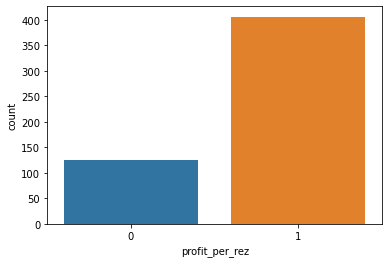

In [10]:
sns.countplot(x='profit_per_rez', data=data)
pass

Загружаем наши факторы

In [11]:
x1 =r'test.xlsx'
x = pd.ExcelFile(x1)
test = x.parse('Лист2')
test.head(5)

,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,учредитель женщина,Первое ЮЛ,Выручка компании в первый год > 30 млн.,Текущее ЮЛ основано до 30 лет,КИ учредителя < 1 млн,Не знает объем выручки,...,"Не знает наценку (рентабельность, прибыль)","Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ
0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
test.isna().sum().sum()

0

In [13]:
lt = list(test.columns)

Пропущенных значений нет

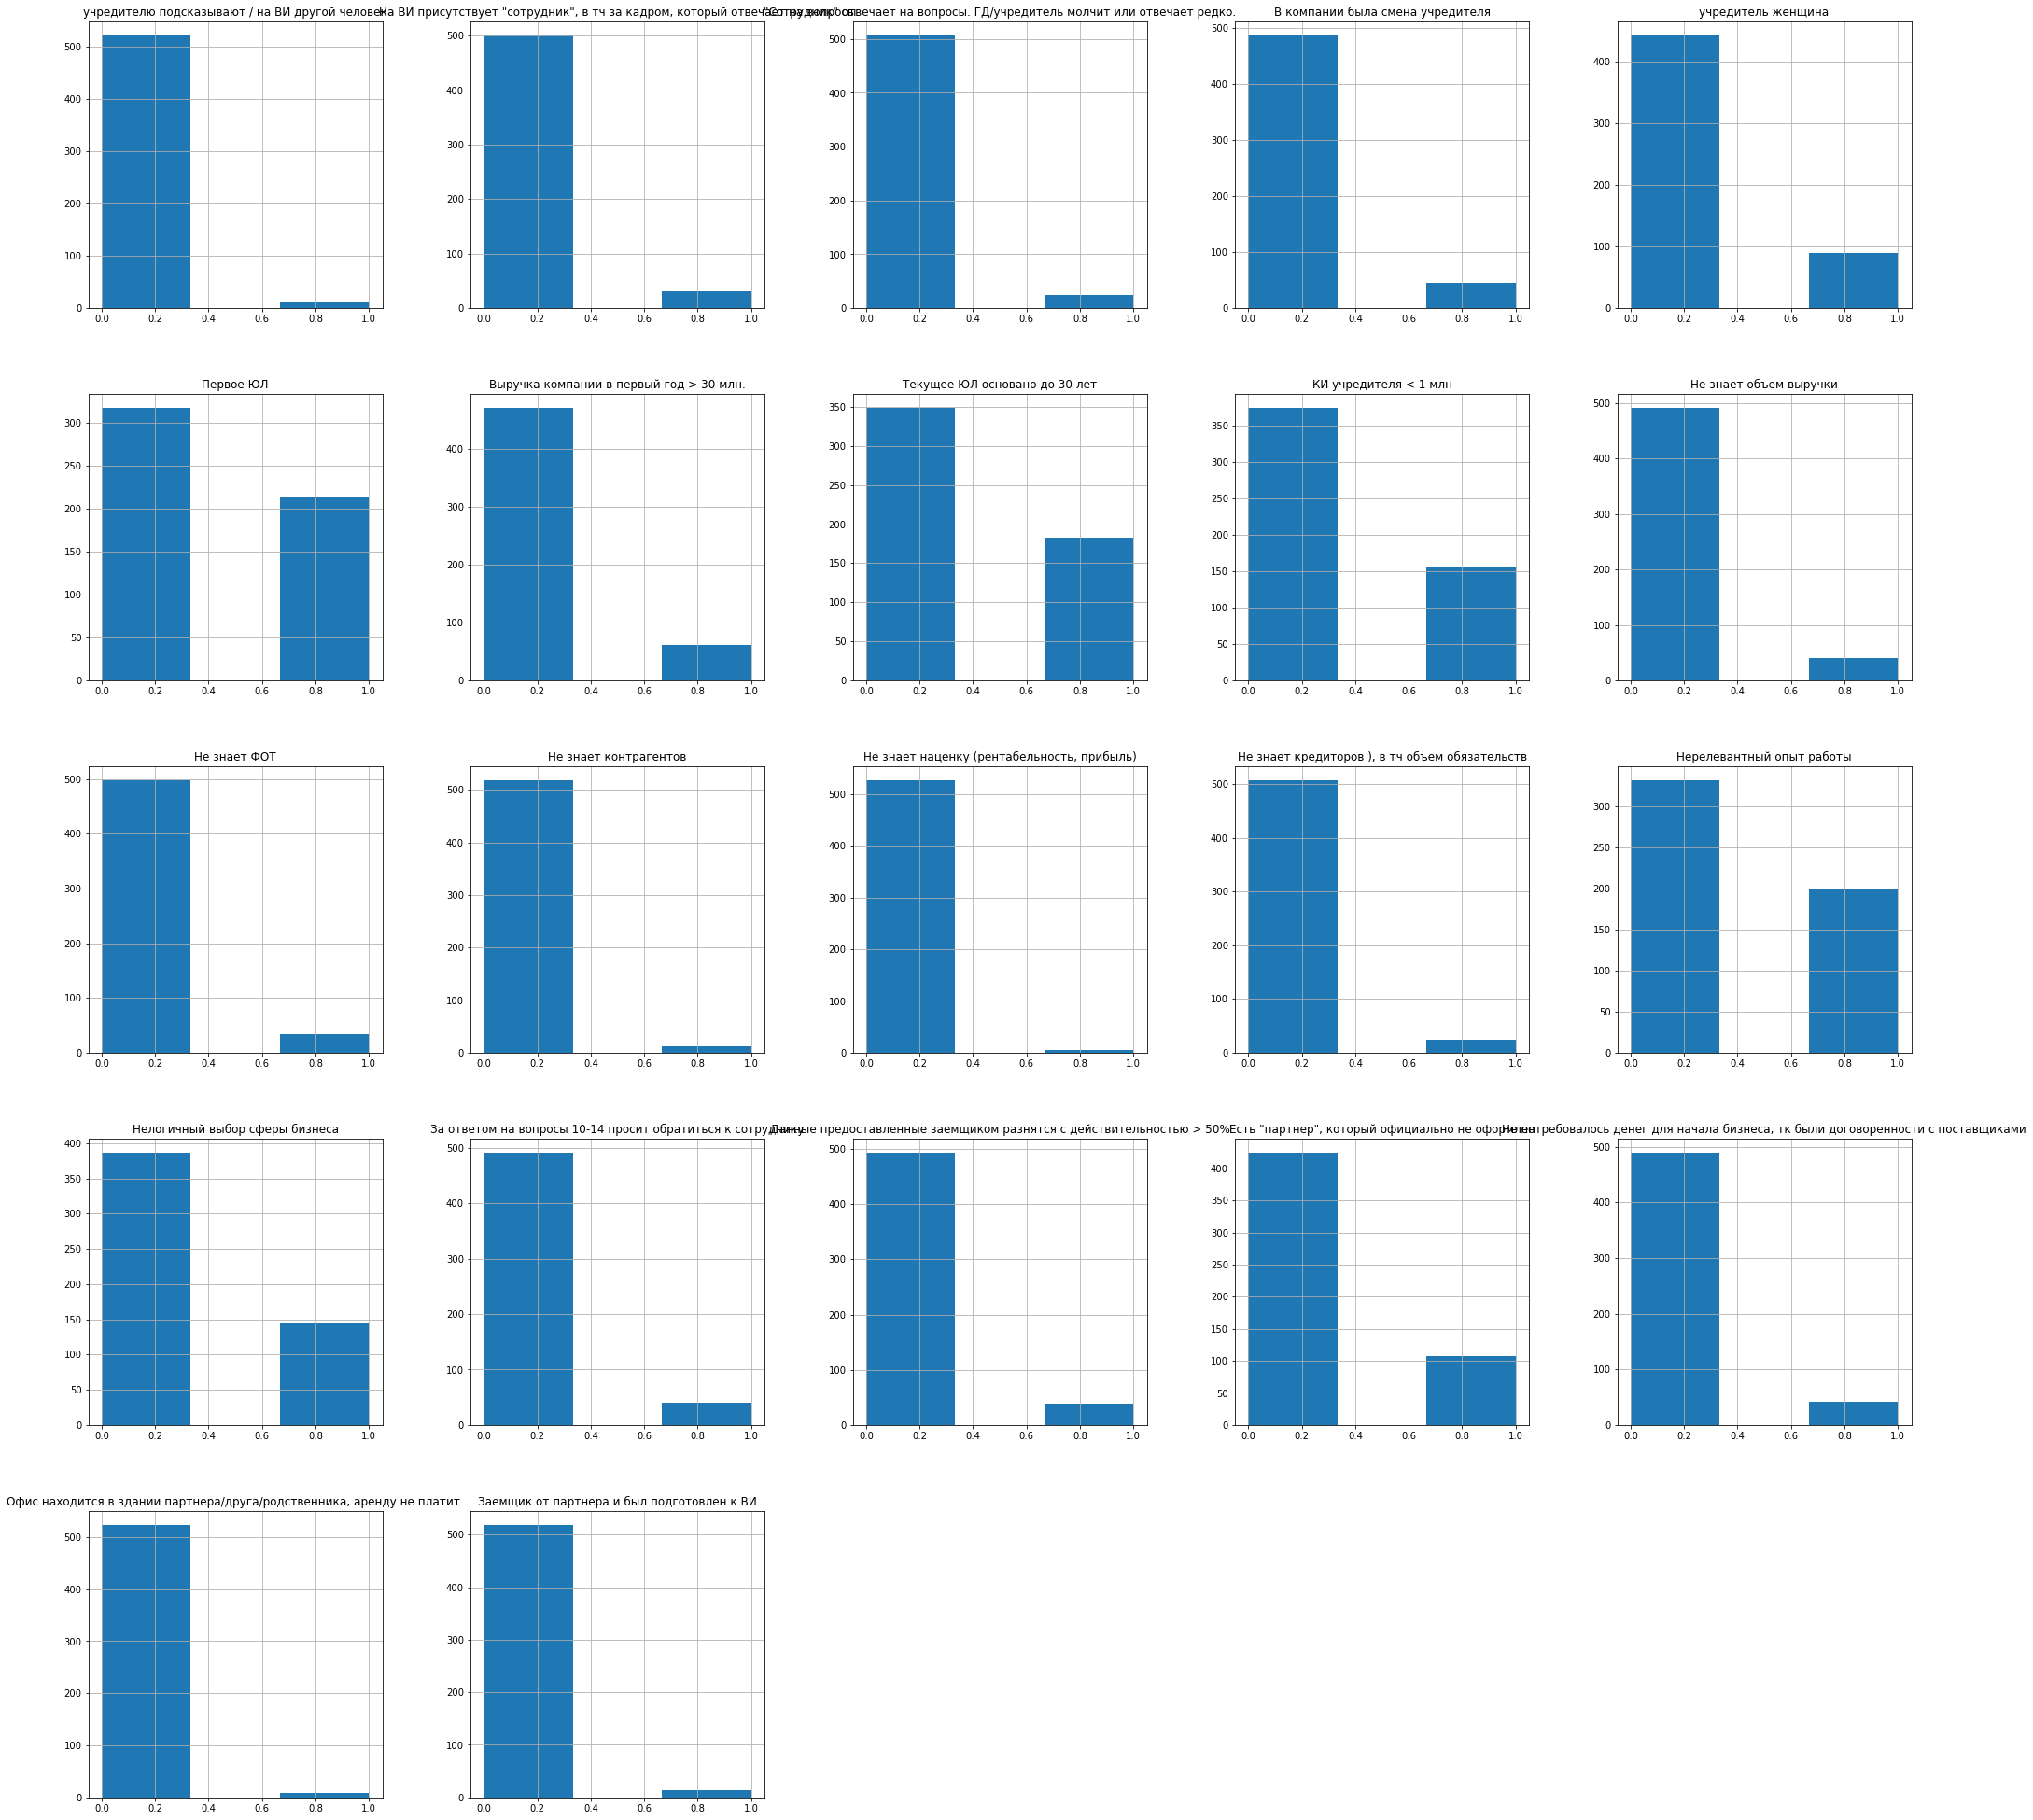

In [14]:
test[lt].hist(figsize=(35, 35),bins=3)
plt.show()

Теперь посмотрим распределение факторов по искомой переменной

In [15]:
test['TARGET'] = data['profit_per_rez']

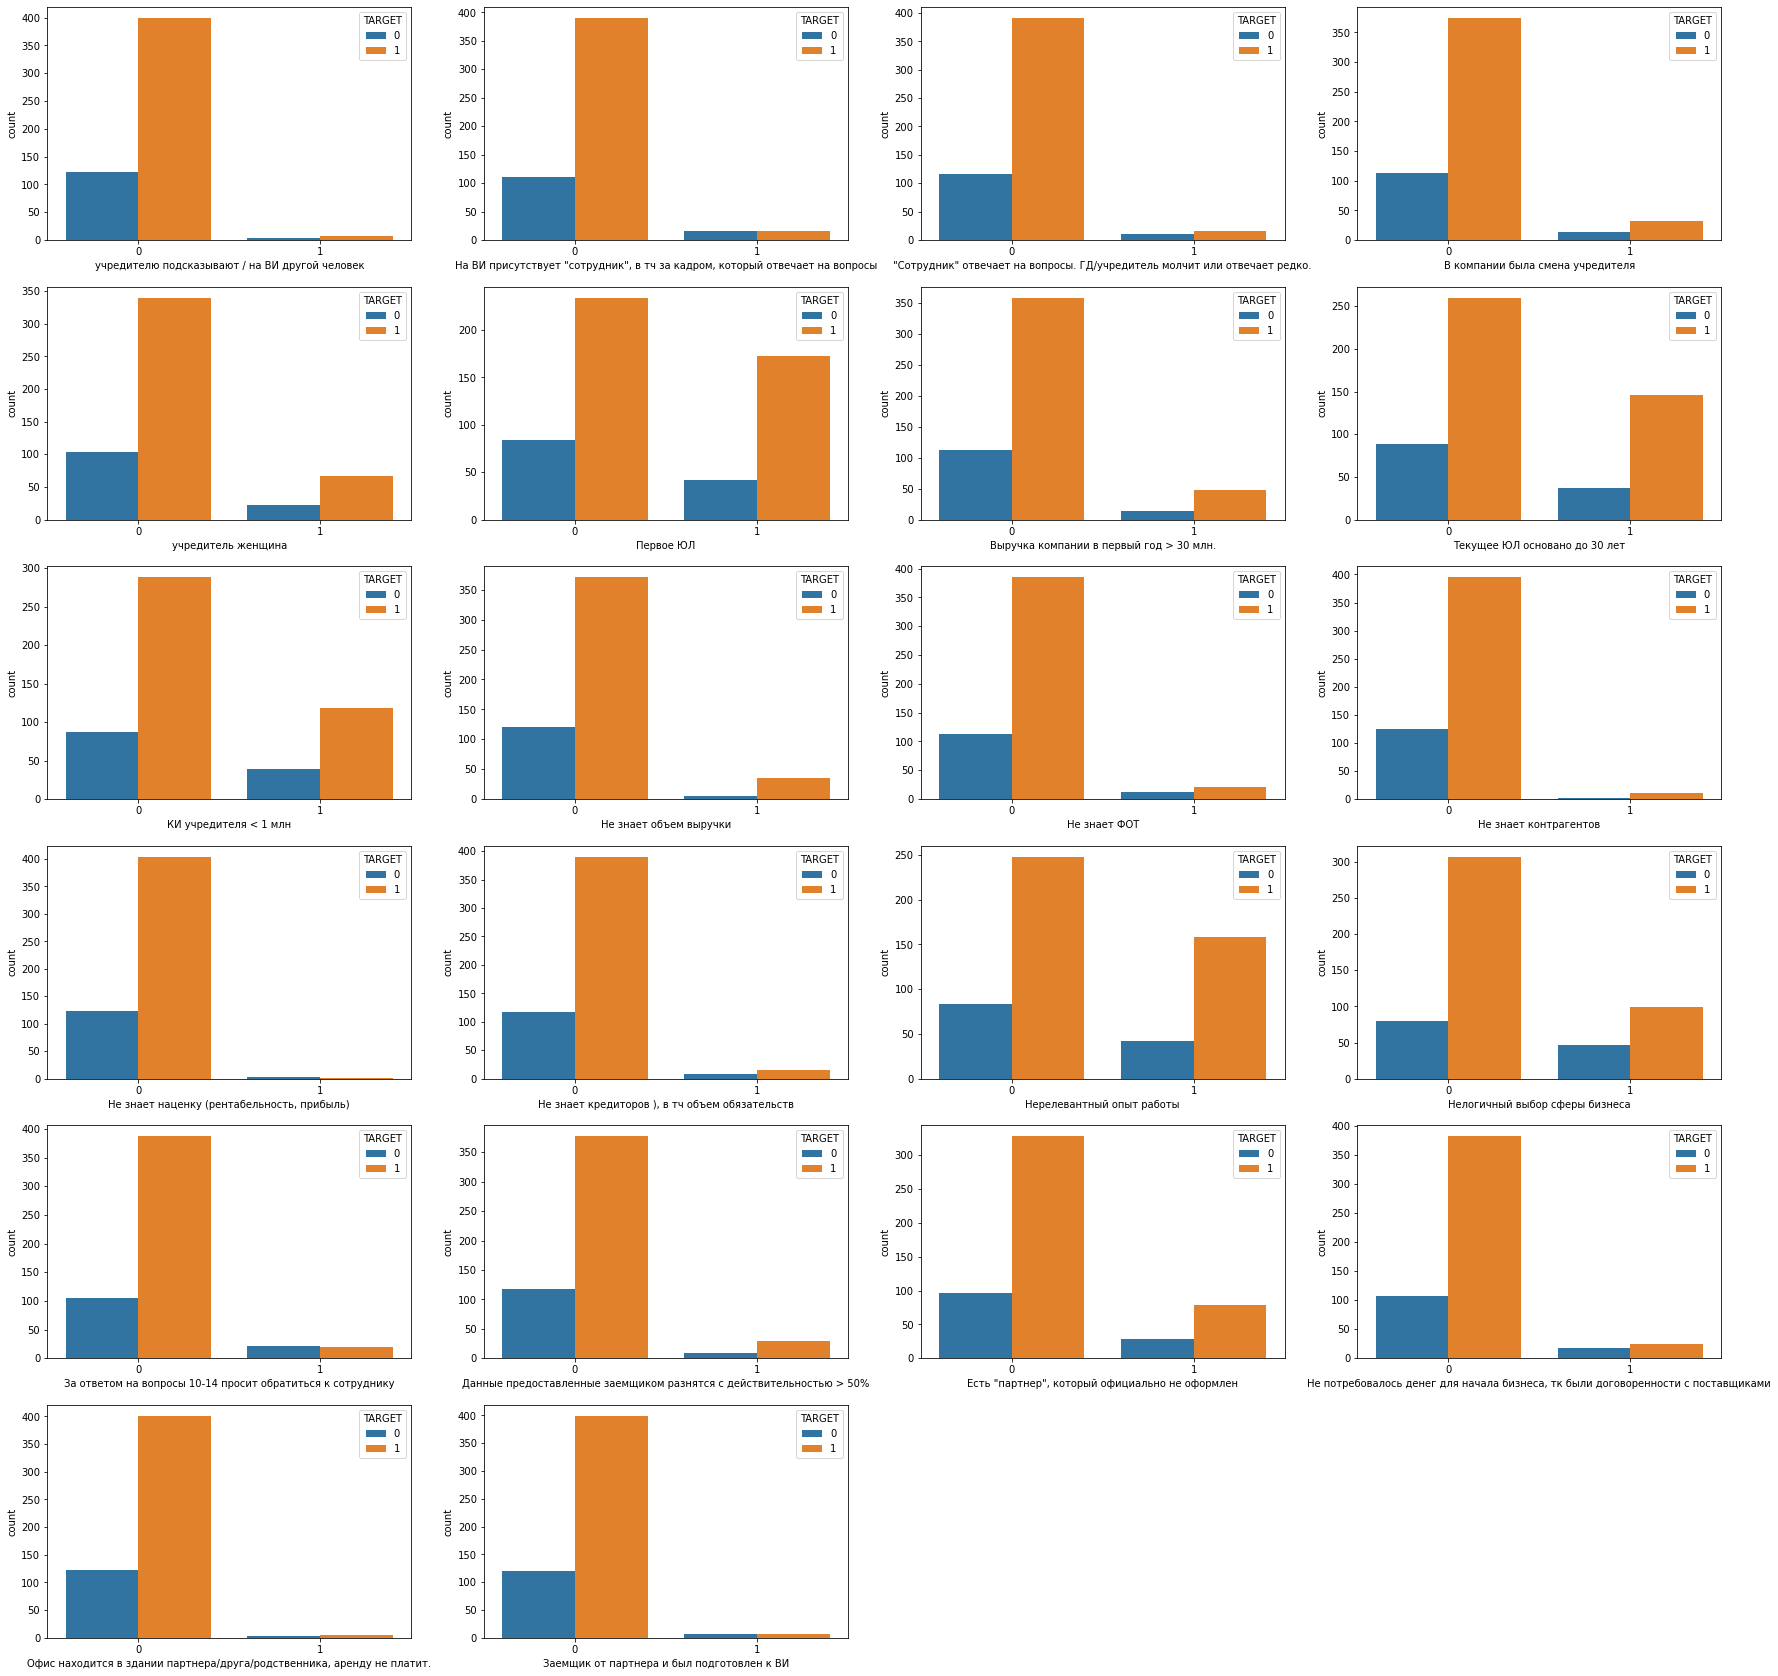

In [16]:
plot_id=1
plt.figure(figsize=(30, 30))
for feature in lt:
    plt.subplot(np.ceil(len(lt) / 4),4,plot_id)
    sns.countplot(x=feature, data=test, hue="TARGET")  
    plot_id+=1
plt.show()    

### Решение задачи классификации

### Построим простую baseline модель:

In [17]:
X = test.drop(['TARGET'], axis=1)
y = test['TARGET']

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(399, 133)

In [19]:
%%time
cval_score = model_selection.cross_validate(linear_model.RidgeClassifier(), X_train, Y_train,
                                          scoring = ["precision",'recall',"roc_auc"],return_train_score=True,cv = 10)

Wall time: 148 ms


In [20]:
ridge=linear_model.RidgeClassifier()
ridge.fit(X_train,Y_train)
Y_train_pr=ridge.predict(X_train)
Y_test_pr=ridge.predict(X_test)

In [21]:
print("RidgeClassifier кросс-валидация train: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(np.mean(cval_score['train_roc_auc']),
                                                                                  np.mean(cval_score['train_precision']),
                                                                                  np.mean(cval_score['train_recall'])))
print("RidgeClassifier кросс-валидация test: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(np.mean(cval_score['test_roc_auc']),
                                                                                  np.mean(cval_score['test_precision']),
                                                                                  np.mean(cval_score['test_recall'])))
print("RidgeClassifier обучающая выборка: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(metrics.roc_auc_score(Y_train,Y_train_pr),
                                                                                             metrics.precision_score(Y_train,Y_train_pr),
                                                                                             metrics.recall_score(Y_train,Y_train_pr)))
print("RidgeClassifier тестовая выборка: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(metrics.roc_auc_score(Y_test,Y_test_pr),
                                                                                             metrics.precision_score(Y_test,Y_test_pr),
                                                                                             metrics.recall_score(Y_test,Y_test_pr)))

RidgeClassifier кросс-валидация train: 	roc_auc:0.73	precision:0.79	recall:0.97
RidgeClassifier кросс-валидация test: 	roc_auc:0.65	precision:0.77	recall:0.95
RidgeClassifier обучающая выборка: 	roc_auc:0.59	precision:0.79	recall:0.97
RidgeClassifier тестовая выборка: 	roc_auc:0.59	precision:0.82	recall:0.97


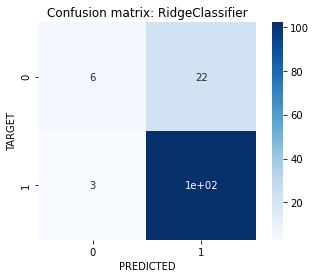

In [22]:
sns.heatmap(metrics.confusion_matrix(Y_test,Y_test_pr),annot=True,cmap="Blues",square=True)
plt.ylabel("TARGET")
plt.xlabel("PREDICTED")
plt.title("Confusion matrix: RidgeClassifier")
plt.show()

#### Попробуем более сложные модели:

In [23]:
%%time
cval_score = model_selection.cross_validate(ensemble.RandomForestClassifier(n_estimators=50),  X_train, Y_train,
                                          scoring = ["precision",'recall',"roc_auc"],return_train_score=True,cv = 10)

Wall time: 1.11 s


In [24]:
fr=ensemble.RandomForestClassifier(n_estimators=50)
fr.fit(X_train,Y_train)
Y_train_pr=fr.predict(X_train)
Y_test_pr=fr.predict(X_test)

In [25]:
print("RandomForestClassifier кросс-валидация train: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(np.mean(cval_score['train_roc_auc']),
                                                                                  np.mean(cval_score['train_precision']),
                                                                                  np.mean(cval_score['train_recall'])))
print("RandomForestClassifier кросс-валидация test: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(np.mean(cval_score['test_roc_auc']),
                                                                                  np.mean(cval_score['test_precision']),
                                                                                  np.mean(cval_score['test_recall'])))
print("RandomForestClassifier обучающая выборка: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(metrics.roc_auc_score(Y_train,Y_train_pr),
                                                                                             metrics.precision_score(Y_train,Y_train_pr),
                                                                                             metrics.recall_score(Y_train,Y_train_pr)))
print("RandomForestClassifier тестовая выборка: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(metrics.roc_auc_score(Y_test,Y_test_pr),
                                                                                             metrics.precision_score(Y_test,Y_test_pr),
                                                                                             metrics.recall_score(Y_test,Y_test_pr)))

RandomForestClassifier кросс-валидация train: 	roc_auc:0.95	precision:0.91	recall:0.98
RandomForestClassifier кросс-валидация test: 	roc_auc:0.61	precision:0.77	recall:0.86
RandomForestClassifier обучающая выборка: 	roc_auc:0.83	precision:0.91	recall:0.97
RandomForestClassifier тестовая выборка: 	roc_auc:0.62	precision:0.84	recall:0.84


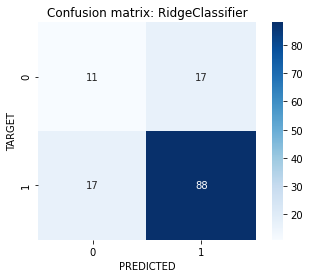

In [26]:
sns.heatmap(metrics.confusion_matrix(Y_test,Y_test_pr),annot=True,cmap="Blues",square=True)
plt.ylabel("TARGET")
plt.xlabel("PREDICTED")
plt.title("Confusion matrix: RidgeClassifier")
plt.show()

Градиентный бустинг

In [27]:
%%time
cval_score = model_selection.cross_validate(ensemble.GradientBoostingClassifier(), X_train, Y_train,
                                          scoring = ["precision",'recall',"roc_auc"],return_train_score=True,cv = 10)

Wall time: 829 ms


In [28]:
gbc=ensemble.GradientBoostingClassifier()
gbc.fit(X_train,Y_train)
Y_train_pr=gbc.predict(X_train)
Y_test_pr=gbc.predict(X_test)

In [29]:
print("GradientBoostingClassifier кросс-валидация train: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(np.mean(cval_score['train_roc_auc']),
                                                                                  np.mean(cval_score['train_precision']),
                                                                                  np.mean(cval_score['train_recall'])))
print("GradientBoostingClassifier кросс-валидация test: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(np.mean(cval_score['test_roc_auc']),
                                                                                  np.mean(cval_score['test_precision']),
                                                                                  np.mean(cval_score['test_recall'])))
print("GradientBoostingClassifier обучающая выборка: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(metrics.roc_auc_score(Y_train,Y_train_pr),
                                                                                             metrics.precision_score(Y_train,Y_train_pr),
                                                                                             metrics.recall_score(Y_train,Y_train_pr)))
print("GradientBoostingClassifier тестовая выборка: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(metrics.roc_auc_score(Y_test,Y_test_pr),
                                                                                             metrics.precision_score(Y_test,Y_test_pr),
                                                                                             metrics.recall_score(Y_test,Y_test_pr)))

GradientBoostingClassifier кросс-валидация train: 	roc_auc:0.87	precision:0.85	recall:0.99
GradientBoostingClassifier кросс-валидация test: 	roc_auc:0.65	precision:0.77	recall:0.92
GradientBoostingClassifier обучающая выборка: 	roc_auc:0.69	precision:0.83	recall:0.99
GradientBoostingClassifier тестовая выборка: 	roc_auc:0.6	precision:0.82	recall:0.94


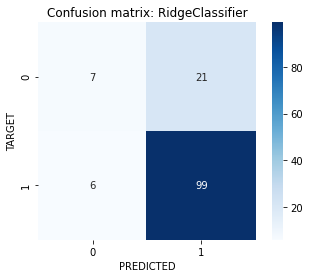

In [30]:
sns.heatmap(metrics.confusion_matrix(Y_test,Y_test_pr),annot=True,cmap="Blues",square=True)
plt.ylabel("TARGET")
plt.xlabel("PREDICTED")
plt.title("Confusion matrix: RidgeClassifier")
plt.show()

### Теперь попробуем убрать коррелированные между собой признаки

Найдем корреляции между бинарными переменными, это делает по специальной формуле. Алгоритм приведен ниже

In [31]:
k = 0.9
sp_1 = []
sp_2 = []
for number,i in enumerate(test.columns[:-1]):
    for j in test.columns[number:]:
        a = sum((test[i]==test[j])&(test[i]==0))
        b = sum((test[i]==test[j])&(test[i]==1))
        c = sum(test[i]>test[j])
        d = sum(test[i]<test[j])
        if (a+b)*(c+d)*(a+c)*(b+d)==0:
            rez = 0
        else:
            rez = (a*d-c*b)/((a+b)*(c+d)*(a+c)*(b+d))**0.5
        if rez>k:
            sp_1+=[i]
            sp_2+=[j]
            print(i,j,rez)
        

учредителю подсказывают / на ВИ другой человек учредитель женщина 0.924968443362205
учредителю подсказывают / на ВИ другой человек Первое ЮЛ 0.9570435974031788
учредителю подсказывают / на ВИ другой человек Выручка компании в первый год > 30 млн. 0.9070887000093838
учредителю подсказывают / на ВИ другой человек Текущее ЮЛ основано до 30 лет 0.9553716701331482
учредителю подсказывают / на ВИ другой человек КИ учредителя < 1 млн 0.9504029914026391
учредителю подсказывают / на ВИ другой человек Нерелевантный опыт работы 0.9558975760872053
учредителю подсказывают / на ВИ другой человек Нелогичный выбор сферы бизнеса 0.9479798772376592
учредителю подсказывают / на ВИ другой человек Есть "партнер", который официально не оформлен 0.9371497146590514
учредителю подсказывают / на ВИ другой человек TARGET 0.9433811126751648
"Сотрудник" отвечает на вопросы. ГД/учредитель молчит или отвечает редко. Первое ЮЛ 0.9028236643345053
"Сотрудник" отвечает на вопросы. ГД/учредитель молчит или отвечает редко

Удалим признаки с большим количеством коррелируемых переменных

In [32]:
test = test.drop(sp_1,axis = 1)
test

,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы",В компании была смена учредителя,учредитель женщина,Первое ЮЛ,Выручка компании в первый год > 30 млн.,Текущее ЮЛ основано до 30 лет,КИ учредителя < 1 млн,Не знает объем выручки,Не знает ФОТ,Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками",TARGET
0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
1,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
528,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
529,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0
530,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1


### Обучим опять простую модель

In [33]:
%%time
X = test.drop(['TARGET'], axis=1)
y = test['TARGET']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
cval_score = model_selection.cross_validate(linear_model.RidgeClassifier(), X_train, Y_train,
                                          scoring = ["precision",'recall',"roc_auc"],return_train_score=True,cv = 10)


Wall time: 146 ms


In [34]:
ridge=linear_model.RidgeClassifier()
ridge.fit(X_train,Y_train)
Y_train_pr=ridge.predict(X_train)
Y_test_pr=ridge.predict(X_test)

In [35]:
print("RidgeClassifier кросс-валидация train: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(np.mean(cval_score['train_roc_auc']),
                                                                                  np.mean(cval_score['train_precision']),
                                                                                  np.mean(cval_score['train_recall'])))
print("RidgeClassifier кросс-валидация test: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(np.mean(cval_score['test_roc_auc']),
                                                                                  np.mean(cval_score['test_precision']),
                                                                                  np.mean(cval_score['test_recall'])))
print("RidgeClassifier обучающая выборка: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(metrics.roc_auc_score(Y_train,Y_train_pr),
                                                                                             metrics.precision_score(Y_train,Y_train_pr),
                                                                                             metrics.recall_score(Y_train,Y_train_pr)))
print("RidgeClassifier тестовая выборка: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(metrics.roc_auc_score(Y_test,Y_test_pr),
                                                                                             metrics.precision_score(Y_test,Y_test_pr),
                                                                                             metrics.recall_score(Y_test,Y_test_pr)))

RidgeClassifier кросс-валидация train: 	roc_auc:0.71	precision:0.79	recall:0.97
RidgeClassifier кросс-валидация test: 	roc_auc:0.66	precision:0.77	recall:0.96
RidgeClassifier обучающая выборка: 	roc_auc:0.58	precision:0.79	recall:0.97
RidgeClassifier тестовая выборка: 	roc_auc:0.62	precision:0.83	recall:0.96


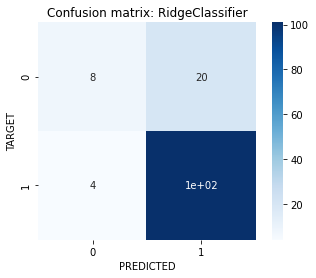

In [36]:
sns.heatmap(metrics.confusion_matrix(Y_test,Y_test_pr),annot=True,cmap="Blues",square=True)
plt.ylabel("TARGET")
plt.xlabel("PREDICTED")
plt.title("Confusion matrix: RidgeClassifier")
plt.show()

Удаление переменных улучшило наш результат

### Попробуем обучить несколько моделей GradientBoostingClassifier и выберем лучшую на кросс-валидации:

Перебирать будем значения главных параметров для модели градиентного бустинга: количество деревьев в ансамбле, максимальная глубина, learning_rate

In [37]:
parameters_grid = {
    'max_depth': [2,3,5],
    "learning_rate":[0.05,0.1],
    "n_estimators":[20,50,100]
}

Из трех метрик "roc_auc","precision",'recall' - приоритетной для нас будет "precision"

In [38]:
gridgb = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(), parameters_grid, return_train_score=False,
                    n_jobs=-1, scoring=["precision",'recall',"roc_auc"],refit="precision")
gridgb.fit(X_train, Y_train)

GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [2, 3, 5],
                         'n_estimators': [20, 50, 100]},
             refit='precision', scoring=['precision', 'recall', 'roc_auc'])

In [39]:
gridgb.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

In [40]:
gbc=ensemble.GradientBoostingClassifier(learning_rate= 0.1, max_depth= 5, n_estimators= 100)
gbc.fit(X_train,Y_train)
Y_train_pr=gbc.predict(X_train)
Y_test_pr=gbc.predict(X_test)

In [41]:
print("GradientBoostingClassifier обучающая выборка: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(metrics.roc_auc_score(Y_train,Y_train_pr),
                                                                                             metrics.precision_score(Y_train,Y_train_pr),
                                                                                             metrics.recall_score(Y_train,Y_train_pr)))
print("GradientBoostingClassifier тестовая выборка: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(metrics.roc_auc_score(Y_test,Y_test_pr),
                                                                                             metrics.precision_score(Y_test,Y_test_pr),
                                                                                             metrics.recall_score(Y_test,Y_test_pr)))

GradientBoostingClassifier обучающая выборка: 	roc_auc:0.78	precision:0.88	recall:0.98
GradientBoostingClassifier тестовая выборка: 	roc_auc:0.57	precision:0.82	recall:0.83


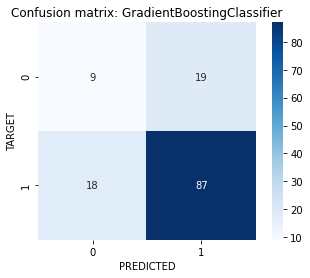

In [42]:
sns.heatmap(metrics.confusion_matrix(Y_test,Y_test_pr),annot=True,cmap="Blues",square=True)
plt.ylabel("TARGET")
plt.xlabel("PREDICTED")
plt.title("Confusion matrix: GradientBoostingClassifier")
plt.show()

In [43]:
print(metrics.classification_report(Y_test,Y_test_pr))

              precision    recall  f1-score   support

           0       0.33      0.32      0.33        28
           1       0.82      0.83      0.82       105

    accuracy                           0.72       133
   macro avg       0.58      0.58      0.58       133
weighted avg       0.72      0.72      0.72       133



Модель GradientBoostingClassifier с параментрами {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}  
Показала себя хуже, чем простая baseline модель (потому что у нас малое количество данных) на всех метриках 
GradientBoostingClassifier тестовая выборка: 	roc_auc:0.55	precision:0.81	recall:0.82  
RidgeClassifier тестовая выборка: 	            roc_auc:0.62	precision:0.83	recall:0.96

Лучший результат получился, когда мы убрали коррелированные переменные и применили классическую baseline модель

### Самые важные признаки для данной модели:

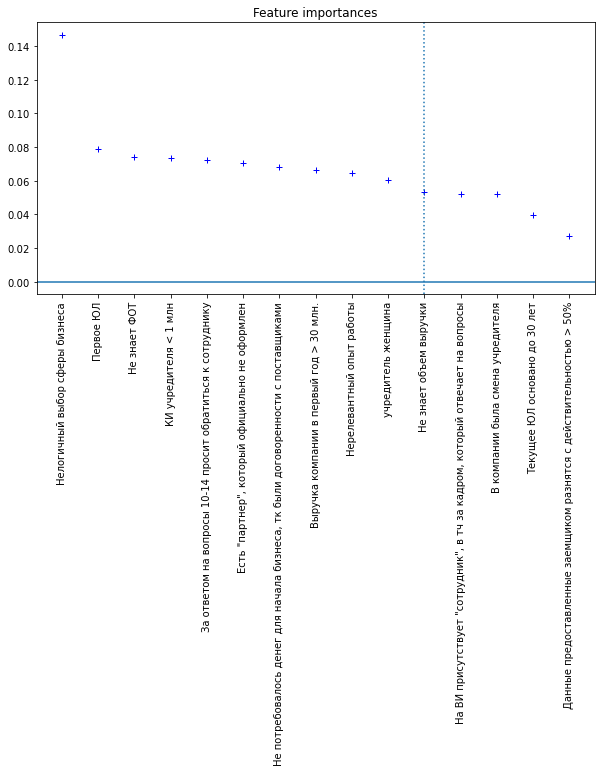

In [45]:
fiorder=np.argsort(-gbc.feature_importances_)
plt.figure(figsize=(10,5))
plt.plot(gbc.feature_importances_[fiorder],"b+")
plt.xticks(range(X_train.shape[1]), X_train.columns[fiorder],rotation=90)
plt.axhline(0.0,linestyle="-")
plt.axvline(10,linestyle=":")
plt.title("Feature importances")
plt.show()

In [60]:
print("10 самых важных признаков:")
for i in (X_train.columns[fiorder[:10]]):
    print(i)

10 самых важных признаков:
Нелогичный выбор сферы бизнеса
Первое ЮЛ
Не знает ФОТ
КИ учредителя < 1 млн
За ответом на вопросы 10-14 просит обратиться к сотруднику
Есть "партнер", который официально не оформлен
Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками
Выручка компании в первый год > 30 млн.
Нерелевантный опыт работы
учредитель женщина
